In [43]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install ninja 2>> install.log
git clone https://github.com/SIDN-IAP/global-model-repr.git tutorial_code 2>> install.log

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dissect.netdissect import nethook, tally
torch.cuda.set_device(0)

In [2]:
device = torch.device('cuda:0')

In [3]:
from parkinsonsNet import Network
model = torch.load("/home/anasa2/pre_trained/parkinsonsNet-rest_mpower-rest.pth")
print(model)

Network(
  (conv1): Sequential(
    (0): Conv1d(3, 8, kernel_size=(5,), stride=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(32, 32, kernel_size=(6,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

In [4]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import math
import json
import time
from matplotlib.pylab import plt
%matplotlib inline 
import itertools

class testMotionData(Dataset):

    def __init__(self, df, users, root_dir = '/home/jupyter/park/', transform=None):
      
        self.dataset = df
        self.root_dir = root_dir
        self.dataArray = []
        self.resultArray = []
        iterData = iter(self.dataset.iterrows())

        k = 0

        for j,z in zip(iterData,tqdm(range(int(len(self.dataset))))):
          j = j[1]
          healthcode = j[3]
        
          label = users.loc[healthcode][0]
          
          #print(j)
          for i in [8]:
            if(not math.isnan(j[i])):
                filedir = str(int(j[i]/10000))
                filename = str(j[i])
                length = len(filename)
                filename = filename[0:length-2]

                if(os.path.isfile(self.root_dir+filedir+"/"+filename+".json"))|(os.path.isfile(self.root_dir+"data"+"/"+filename+".json")):
                  if(os.path.isfile(self.root_dir+filedir+"/"+filename+".json")):
                    f = open(self.root_dir+filedir+"/"+filename+".json")
                  else:
                    f = open(self.root_dir+"data/"+filename+".json")
                try:
                    data = json.load(f)
                except:
                    continue
                self.dataArray.append([])
                self.dataArray[k].append([])
                self.dataArray[k].append([])
                self.dataArray[k].append([])
                for i in range(0,len(data),2):
                      x = data[i].get("rotationRate")
#                       print(i)
                      self.dataArray[k][0].append(x["x"])
                      self.dataArray[k][1].append(x["y"])
                      self.dataArray[k][2].append(x["z"])
            
                stdev = np.std(np.asarray(self.dataArray[k]))
                mean = np.mean(np.asarray(self.dataArray[k]))
                self.dataArray[k] = ((np.asarray(self.dataArray[k])-mean)/stdev).tolist()
                        
                self.dataArray[k][0] = correct_batch(self.dataArray[k][0])
                self.dataArray[k][1] = correct_batch(self.dataArray[k][1])
                self.dataArray[k][2] = correct_batch(self.dataArray[k][2])
                
                
                

                if(label):
                  self.resultArray.append(1)
                else:
                  self.resultArray.append(0)
                

                k = k + 1



        self.dataArray = np.asarray(self.dataArray)
        unique, counts = np.unique(np.array(self.resultArray), return_counts=True)
        print(dict(zip(unique, counts)))



    def __len__(self):
        return len(self.resultArray)

    def __getitem__(self, idx):
        sample = {'data': self.dataArray[idx], 'result': self.resultArray[idx]}

        return sample

In [5]:
import numpy as np
def pad_zero(arr,length):
    while(len(arr)<length):
        arr = np.append(arr,0)
    return arr[:length]

In [6]:
def trans_equal(ten,length=1000):
    return torch.tensor([pad_zero(ten[0][0].cpu().numpy(),length),pad_zero(ten[0][1].cpu().numpy(),length),pad_zero(ten[0][2].cpu().numpy(),length)])

## Find Masks

In [7]:
from torchvision.utils import save_image
import os
import pandas as pd
from signal_purtubation import extremal_perturbation
import signal_purtubation


masked = []
model.to(device).eval()
model = model.float()

dataloader = torch.load("/home/anasa2/originalParkinsonsDataloaders/val_loader.pth")

      

In [8]:
# counter to keep count of the conv layers
counter = 0 
modules = {}
for top,module in model.named_children():
    for block,m1 in module.named_children():
        if type(m1) == nn.Conv1d:
            modules.update({""+top:m1})
            counter += 1
          
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 8


In [9]:
print(modules)

{'conv1': Conv1d(3, 8, kernel_size=(5,), stride=(1,)), 'conv2': Conv1d(8, 16, kernel_size=(6,), stride=(1,)), 'conv3': Conv1d(16, 32, kernel_size=(7,), stride=(1,)), 'conv4': Conv1d(32, 32, kernel_size=(6,), stride=(1,)), 'conv5': Conv1d(32, 64, kernel_size=(6,), stride=(1,)), 'conv6': Conv1d(64, 64, kernel_size=(7,), stride=(1,)), 'conv7': Conv1d(64, 128, kernel_size=(6,), stride=(1,)), 'conv8': Conv1d(128, 256, kernel_size=(7,), stride=(1,))}


In [10]:
model = nethook.InstrumentedModel(model)
model.eval()

InstrumentedModel(
  (model): Network(
    (conv1): Sequential(
      (0): Conv1d(3, 8, kernel_size=(5,), stride=(1,))
      (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv1d(8, 16, kernel_size=(6,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv1d(32, 32, kernel_size=(6,), stride=(1,))
      (1): BatchNorm1d(32, eps=1e-

In [11]:
model.cuda();

In [12]:
itr = iter(dataloader)

In [13]:
batch = itr.next()
sample = batch["data"]
sample_label = batch["result"]

In [14]:
while(True):
    try: 
        batch = next(itr) 
    except:
        break 

    sample  = torch.cat((sample, batch["data"]), dim=0)
    sample_label  = torch.cat((sample_label, batch["result"]), dim=0)


In [15]:
datapoint = torch.FloatTensor(sample[0].cpu().float()).to(device)
datapoint_label = sample_label[0]


data = torch.FloatTensor(sample.cpu().float()).to(device)

In [16]:
# Sample output
prediction = torch.sigmoid(model(datapoint.unsqueeze(0)))
prediction

tensor([[0.4205]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [28]:
from operator import itemgetter
from captum.attr import LayerActivation,LayerConductance, LayerGradientXActivation, NeuronConductance
from tqdm.notebook import tqdm

def get_topk_units(model, inputs, labels, target, sample_size=100):
  activations = {}
  count = 0
  for idx in tqdm(range(len(inputs))):
    if(count > sample_size):
      break
    if(labels[idx].item()==target):
      count+=1
      input = inputs[idx]
      for layer in modules:
        attr_algo = LayerConductance(model, modules[layer])
        attributions = attr_algo.attribute(input.unsqueeze(0).cuda()).squeeze()
        for i, unit in enumerate(attributions.squeeze()):
          if((layer,i) not in activations):
            activations.update({(layer,i):sum(unit).item()})
          else:
            activations[(layer,i)] += sum(unit).item()


  results = []
  for (key, value), top in zip(sorted(activations.items(), key = itemgetter(1), reverse = True),range(50)):
        results.append((key, value))
        

  return results



In [29]:
layers = get_topk_units(model,data, sample_label, target=0, sample_size=10)
print(layers)


[(('conv3', 12), 53.5680878162384), (('conv5', 37), 44.73418700695038), (('conv3', 27), 39.53353726863861), (('conv5', 41), 25.88316786289215), (('conv4', 8), 22.262177109718323), (('conv6', 60), 20.926531195640564), (('conv5', 56), 16.549827456474304), (('conv5', 15), 13.025032330304384), (('conv2', 1), 12.930001802742481), (('conv6', 15), 12.390349179506302), (('conv4', 5), 11.560675352811813), (('conv1', 7), 11.121374268084764), (('conv5', 21), 10.698958814144135), (('conv4', 30), 10.311916530132294), (('conv2', 0), 10.264536768198013), (('conv6', 53), 9.537217572331429), (('conv6', 37), 9.114233195781708), (('conv5', 40), 9.042821153998375), (('conv3', 29), 8.760749742388725), (('conv6', 44), 8.073811046779156), (('conv6', 16), 8.007254734635353), (('conv6', 39), 7.612704813480377), (('conv7', 75), 7.470648258924484), (('conv2', 10), 6.758099768310785), (('conv6', 34), 6.62586171773728), (('conv6', 27), 6.5908888429403305), (('conv6', 57), 5.792868219316006), (('conv1', 0), 5.3020

In [30]:
layers_1 = get_topk_units(model,data, sample_label, target=1, sample_size=10)
print(layers_1)


[(('conv3', 12), 52.31035614013672), (('conv5', 37), 49.313931465148926), (('conv3', 27), 37.67655372619629), (('conv5', 41), 28.29087269306183), (('conv2', 0), 26.79880677163601), (('conv6', 60), 24.030630230903625), (('conv1', 7), 23.484099239110947), (('conv4', 8), 22.41730371117592), (('conv5', 56), 17.73547187447548), (('conv2', 1), 15.865225315093994), (('conv4', 5), 14.813593685626984), (('conv5', 15), 13.802132070064545), (('conv1', 3), 13.340545136481524), (('conv5', 21), 12.307004749774933), (('conv3', 29), 11.448666200041771), (('conv1', 2), 11.031183173879981), (('conv6', 44), 10.268265277147293), (('conv5', 40), 9.999189496040344), (('conv6', 15), 9.608098676428199), (('conv1', 0), 9.287760555744171), (('conv6', 34), 8.415373027324677), (('conv6', 37), 8.394598960876465), (('conv7', 75), 8.29227739572525), (('conv6', 53), 7.951751064509153), (('conv4', 19), 7.590820163488388), (('conv6', 16), 7.127092517912388), (('conv2', 9), 6.996872364543378), (('conv3', 25), 6.5989010

In [72]:
try:
  os.system("rm -rf results")
except:
  None

In [73]:
sample_size = 1
layername = layers_1[6][0][0]
unit = layers_1[6][0][1]
model.retain_layer(layername)


def max_activations(batch, *args):
    image_batch = data.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).max(2)[0]

def mean_activations(batch, *args):
    image_batch = data.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).mean(2)

topk = tally.tally_topk(
    max_activations,
    dataset=data,
    sample_size=sample_size,
    batch_size=1,
    cachefile='results/cache_mean_topk.npz'
)

top_indexes = topk.result()[1]

In [74]:
print(model.retained_layer(layername).shape)

torch.Size([4137, 8, 1998])


In [75]:
def get_window(a, thresh, window_size=20):
    m = a>thresh
    me = np.r_[False,m,False]
    idx = np.flatnonzero(me[:-1]!=me[1:])
    lens = idx[1::2]-idx[::2]
    return idx[::2][(lens >= window_size).argmax()]

In [76]:
from matplotlib import patches
def plot_signal(signals, boundaries, label):
    i = 0
    fig = plt.figure(figsize=(40,40))    
    ax = fig.add_subplot(4, 4, i + 1)
    i += 1
    for s,b in zip(signals,boundaries):
        rect = patches.Rectangle((b[0],-25),b[1],40,linewidth=1,edgecolor='black' ,facecolor='none')
        ax.add_patch(rect)
        ax.set_title("Entire Signal")

        ax.plot(s[0],color='blue',label='x')
        ax.plot(s[1],color='green',label='y')
        ax.plot(s[2],color='red',label='z')
     
        ax = fig.add_subplot(4, 4, i + 1)
        i += 1
        
        ax.set_title("Target Region From "+str(b[0])+" to "+str(b[1])+" For Label: "+str(label.item()))

        ax.plot(s[0][b[0]:b[1]],color='blue',label='x')
        ax.plot(s[1][b[0]:b[1]],color='green',label='y')
        ax.plot(s[2][b[0]:b[1]],color='red',label='z')


    plt.legend()
    plt.show()

In [77]:
def viz_signal(signal_index, unit_index, signals, signal_labels, layername, threshold=0.8, window_size=20):
    a = model.retained_layer(layername)[signal_index].cpu().numpy()
    try:
        lower_bound = get_window(a[unit_index],threshold,window_size=window_size)
        plot_signal([signals[signal_index].cpu().numpy()],[[lower_bound,lower_bound+window_size]],signal_labels[signal_index])
    except:
        return


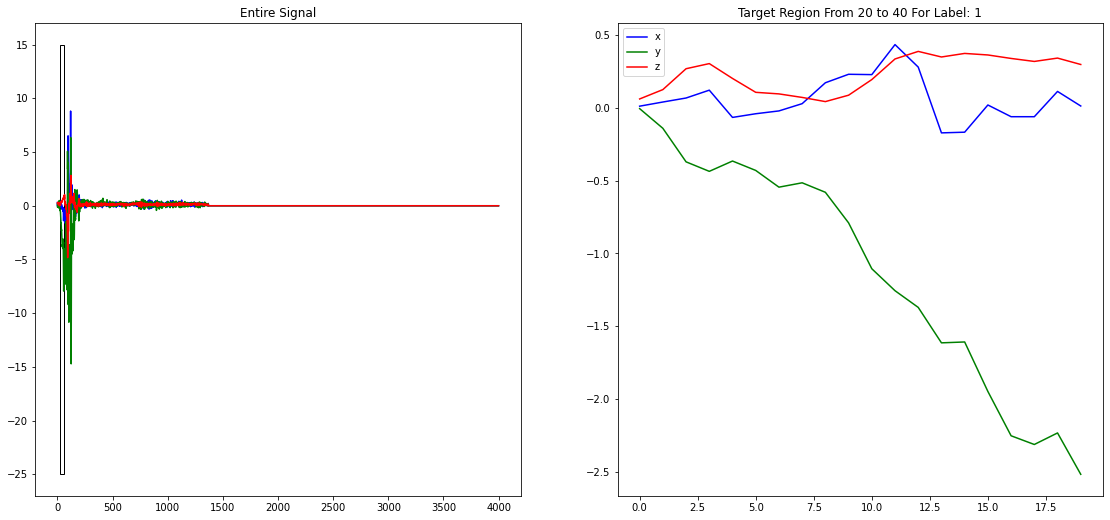

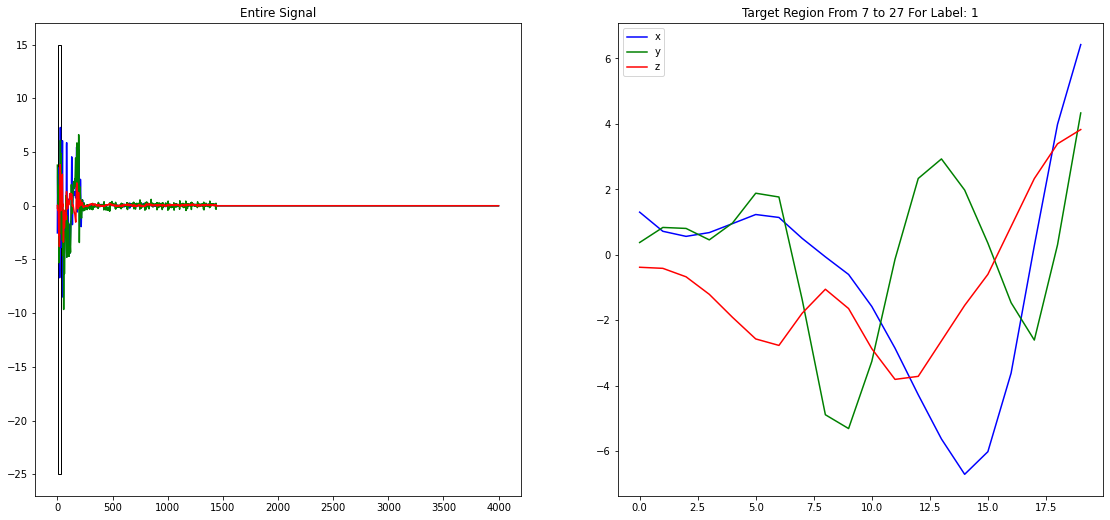

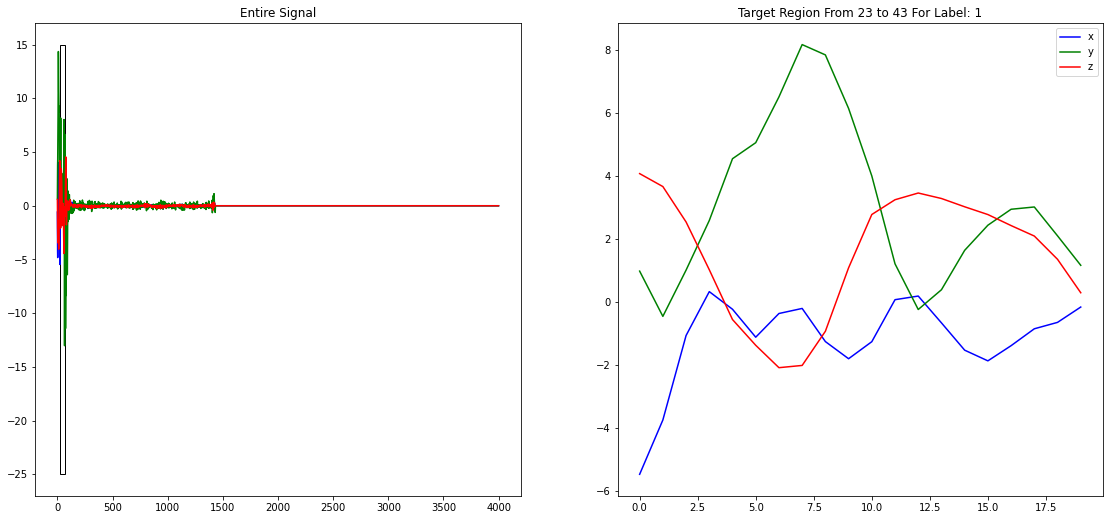

In [78]:
topk = 3
for i in top_indexes[unit][:topk]:    
    viz_signal(i,unit,data,sample_label, layername)

In [79]:
model.stop_retaining_layers([layername])
model.retain_layer(layername)


In [80]:
# random_point = torch.FloatTensor(np.random.rand(3,4000)*10).unsqueeze(0)
output= model(datapoint.unsqueeze(0).cuda());
# output

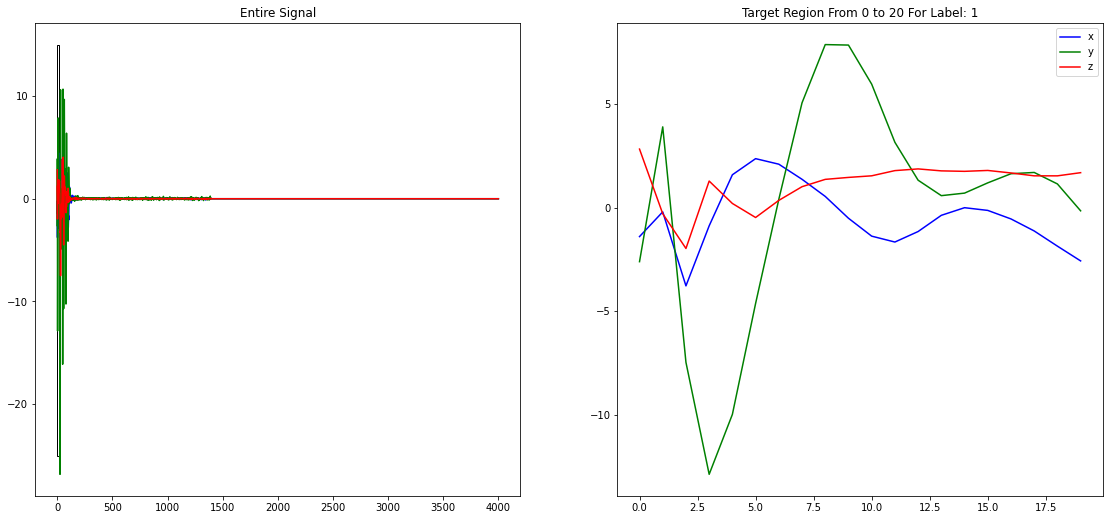

In [71]:
viz_signal(0,unit,[datapoint],[datapoint_label], layername)